\newpage

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from fancyimpute import SoftImpute
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

(CVXPY) Apr 18 08:53:48 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


#### 1. Classification Problem Idenitification

Chronic Kidney Disease (CKD) is the progressive loss of kindey function (@sanmarchi2023predict). The progression of the disease can be attributed to a number of factors. The implications of CKD are large, especially for the quality of life of those afflicted as well as for the sustainability of national health systems (@sanmarchi2023predict). Thus, it is important to use the information available about patient health to predict the diagnosis of CKD.

The dataset from the Early Stage of Indians Chronic Kidney Disease (CKD) project (@misc_chronic_kidney_disease_336) contains information on a variety of health factors, including blood pressure, red blood cell count, albumin concentration, blood sugar, whether or not one has diabetes mellitus, and more.

This dataset will be used to predict whether an individual will develop CKD. 

In [52]:
df = pd.read_csv("https://archive.ics.uci.edu/static/public/336/data.csv")
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


The `df` dataframe now has the Chronic Kidney Disease dataset.

### 2. Variable Transformation

Based on the variable types (see below), we have some nominal and some numerical. Looking at the data dictionary, we can confirm that there are 14 nominal and 10 numerical variables (total of 24 predictor variables). The `class` variable is the response variable (which we are predicting).

For numerical variables: We will have to handle missing values and then we can scale the observations (see question 5 for scaling).

For nominal variables: we must convert to categorical using `pd.categorical`.

In [53]:
df.dtypes # original data set variable types

cols_cat = ['sg','al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane','class']
for col in cols_cat:
    df[col] = pd.Categorical(df[col])

df.dtypes # after converting nominal to categorical

age       float64
bp        float64
sg       category
al       category
su       category
rbc      category
pc       category
pcc      category
ba       category
bgr       float64
bu        float64
sc        float64
sod       float64
pot       float64
hemo      float64
pcv       float64
wbcc      float64
rbcc      float64
htn      category
dm       category
cad      category
appet    category
pe       category
ane      category
class    category
dtype: object

In [54]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 3. Dataset Overview

In [55]:
df.shape

(400, 25)

In [56]:
df.describe()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [57]:
df.describe(include='category')

,sg,al,su,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
count,353.00,354.0,351.0,248,335,396,396,398,398,398,399,399,399,400
unique,5.00,6.0,6.0,2,2,2,2,2,3,2,2,2,2,3
top,1.02,0.0,0.0,normal,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
freq,106.00,199.0,290.0,201,259,354,374,251,260,364,317,323,339,248


c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


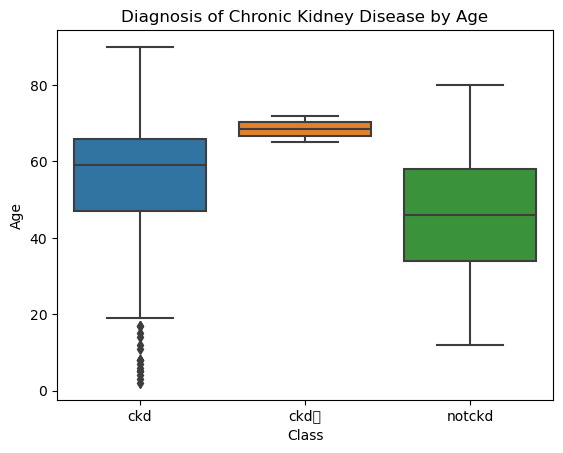

In [58]:
sns.boxplot(x = df['class'], y = df['age'])
plt.title('Diagnosis of Chronic Kidney Disease by Age')
plt.xlabel('Class')
plt.ylabel('Age')
plt.show()

There are 400 observations and 25 variables, out of which 14 are numerical and 11 are nominal (listed above). There are also many missing values in many variable categories, which is why all of the variable counts are not equal to 400. Of the 25 variables, one is the `class` variable, representing the response variable, i.e. tells us whether the individual has CKD or not.

The most notable variables are `class` and `dm` because they are non-binary (they have another entry which we cannot interpret). This is seen from the table of the categorical variables which are described above (these two variables have 3 categories instead of 2). We will treat these as missing values and remove in question 5. This explains the plot in the middle of the first boxplot (Diagnosis of CKD by Age) above which does not fall in `ckd` or `notckd`.

There are three variables, `sg`,`al`,`su`, which have more than 2 categories (non-binary). Nonetheless, despite the entries being numbers, we know from the data dictionary that they are categories, and have been converted accordingly.

### 4. Association between Variables

We will create a correlation matrix to visualize the association between variables.

<Axes: >

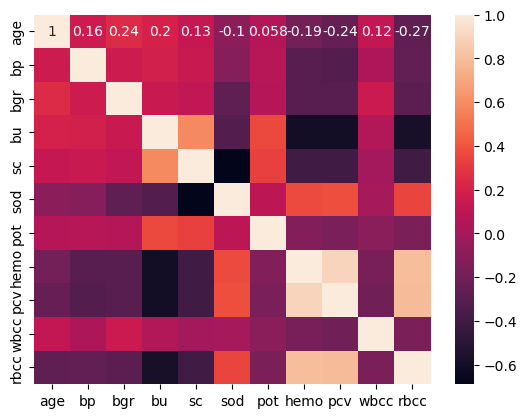

In [59]:
ckd_excluded = df.select_dtypes(
    include = ['float64']
    )


sns.heatmap(ckd_excluded.corr(), annot=True)

Some variables have little relationship, such as serum creatine and white blood cell count, as indicated with a coefficient of correlation of about 0.0. However, other variables, such as red blood cell count and hemoglobin have a very strong positive correlation, and others such as albumin and red blood cell count have a strong negative correlation.

Since it appears that there is co-linearity, the presence of strong linear relationships among predictor variables, the regression coefficients generated by a logistic regression model, for instance, would have large sampling errors. Feature selection should seek to remove some predictor variables that are correlated to reduce co-linearity.

### 5. Missing Value Analysis and Handling

Note: `dm` variable represents whether the individual has diabetes mellitus or not and `class` represents wehter the individual has CKD or not.

We will start by removing the observations that are missing from the `class` and `dm` variables. These two variables have an odd entry (that falls in neither of the two categories identified in their data dictionary). We will simply remove the observations with the odd value for the `class` variable so as not to falsely assume the entry. For the `dm` variable, we will call it a missing value instead of the odd entry.

Then, we will handle the missing values for all **numerical variables** by imputing the missing values via matrix factorization. This involves estimating the missing values. The reason we cannot remove all of the observations with missing values because that will constitute more than half of the observations. This allows

Then, for the **catergorical variables**, we will deal with them by inputing the most common value for each variable. Notice below that almost all variables have value counts greatest in a single category. While doing so may introduce a certain degree of bias, most of the variables skewness will be maintained. Since the variables are categorical, using mode is good choice (since we can't use other measures like mean). Removing these rows will not be an option because it will result in the loss of very important data.

In [60]:
# There are no missing values in the response variable
df['class'].isna().sum()

0

In [61]:
# Dropping the 2 rows where the class variable is 'ckd\t'
df = df[df['class'] != 'ckd\t']

In [62]:
# Identify which observation has '\tno' in the 'dm' column: it is the 188th observation
np.where(df['dm'] == '\tno')

# Now we change it to a missing value
df.loc[[188], 'dm'] = np.NaN

In [63]:
# Checking to see the new observation count
df.shape

(398, 25)

We see that after removing the missing variables, we have 398 observations.

Now we handle the missing values for the **numerical variables** using matrix factorization.

In [64]:
# num is the numerical column names
num = df.select_dtypes(
    include = ['float64']
    ).columns

# num_col are the numerical columns themselves
num_col = df[num]

In [65]:
num_col_softimpute = SoftImpute().fit_transform(num_col)

[SoftImpute] Max Singular Value of X_init = 152278.989452
[SoftImpute] Iter 1: observed MAE=39.240147 rank=1
[SoftImpute] Iter 2: observed MAE=38.661306 rank=1
[SoftImpute] Iter 3: observed MAE=38.614076 rank=1
[SoftImpute] Iter 4: observed MAE=38.602324 rank=1
[SoftImpute] Iter 5: observed MAE=38.595829 rank=1
[SoftImpute] Iter 6: observed MAE=38.590187 rank=1
[SoftImpute] Iter 7: observed MAE=38.584774 rank=1
[SoftImpute] Iter 8: observed MAE=38.579487 rank=1
[SoftImpute] Iter 9: observed MAE=38.574308 rank=1
[SoftImpute] Iter 10: observed MAE=38.569231 rank=1
[SoftImpute] Iter 11: observed MAE=38.564257 rank=1
[SoftImpute] Iter 12: observed MAE=38.559383 rank=1
[SoftImpute] Iter 13: observed MAE=38.554605 rank=1
[SoftImpute] Iter 14: observed MAE=38.549923 rank=1
[SoftImpute] Iter 15: observed MAE=38.545333 rank=1
[SoftImpute] Iter 16: observed MAE=38.540835 rank=1
[SoftImpute] Iter 17: observed MAE=38.536425 rank=1
[SoftImpute] Iter 18: observed MAE=38.532104 rank=1
[SoftImpute] It

In [66]:
num_imputed = pd.DataFrame(num_col_softimpute, columns=num_col.columns)

In [67]:
df[num] = num_imputed.values
df[num].isna().sum()

age     0
bp      0
bgr     0
bu      0
sc      0
sod     0
pot     0
hemo    0
pcv     0
wbcc    0
rbcc    0
dtype: int64

In [68]:
# Standardize and Scaling Variables
scaler = StandardScaler()
df[num] = scaler.fit_transform(df[num])
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,-0.150963,0.280416,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,-0.227745,...,0.691193,0.357276,0.795492,yes,yes,no,good,no,no,ckd
1,-2.443608,-1.567461,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,-0.574190,...,0.320898,-0.049732,-0.252580,no,no,no,good,no,no,ckd
2,0.631891,0.280416,1.010,2.0,3.0,normal,normal,notpresent,notpresent,3.462582,...,-0.111112,0.289441,0.075962,no,yes,no,poor,no,yes,ckd
3,-0.150963,-0.335543,1.005,4.0,0.0,normal,abnormal,present,notpresent,-0.276623,...,-0.049397,0.108548,0.206107,yes,no,no,poor,yes,yes,ckd
4,0.016791,0.280416,1.010,2.0,0.0,normal,normal,notpresent,notpresent,-0.411039,...,0.135751,0.244218,0.523469,no,no,no,good,no,no,ckd


The **categorical variables** still have missing values. We will deal with them by inputing the most common value for each variable.

In [69]:
cat_columns = ['sg','al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']

In [70]:
for col in cat_columns:
    print(df[col].value_counts())

sg
1.020    106
1.010     83
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64
al
0.0    199
1.0     44
3.0     43
2.0     42
4.0     24
5.0      1
Name: count, dtype: int64
su
0.0    289
2.0     18
3.0     14
1.0     13
4.0     13
5.0      3
Name: count, dtype: int64
rbc
normal      200
abnormal     47
Name: count, dtype: int64
pc
normal      259
abnormal     75
Name: count, dtype: int64
pcc
notpresent    353
present        41
Name: count, dtype: int64
ba
notpresent    372
present        22
Name: count, dtype: int64
htn
no     251
yes    145
Name: count, dtype: int64
dm
no      260
yes     135
\tno      0
Name: count, dtype: int64
cad
no     362
yes     34
Name: count, dtype: int64
appet
good    317
poor     80
Name: count, dtype: int64
pe
no     321
yes     76
Name: count, dtype: int64
ane
no     338
yes     59
Name: count, dtype: int64


In [71]:
impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(df[cat_columns])

df[cat_columns] = impute_mode.transform(df[cat_columns])

In [72]:
# Convert Appropriate Categorical Variables to 0, 1 bins because of the unusual values
df['rbc'] = df['rbc'].map({'normal':1, 'abnormal':0})
df['pc'] = df['pc'].map({'normal':1, 'abnormal':0})
df['pcc'] = df['pcc'].map({'present':1, 'notpresent':0})
df['ba'] = df['ba'].map({'present':1, 'notpresent':0})
df['htn'] = df['htn'].map({'yes':1, 'no':0})
df['dm'] = df['dm'].map({'yes':1, 'no':0})
df['cad'] = df['cad'].map({'yes':1, 'no':0})
df['appet'] = df['appet'].map({'good':1, 'poor':0})
df['pe'] = df['pe'].map({'yes':1, 'no':0})
df['ane'] = df['ane'].map({'yes':1, 'no':0})
df['class'] = df['class'].map({'ckd':1, 'notckd':0})

In [73]:
# Confirming that all missing values have been handled
df.isna().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

## 7: Subgroup Analysis

Examining the subgroups of patients with or without hypertension, diabetes, or CAD may be of interest. The plots below will specifically visualize how blood pressure varies based on these values.

c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


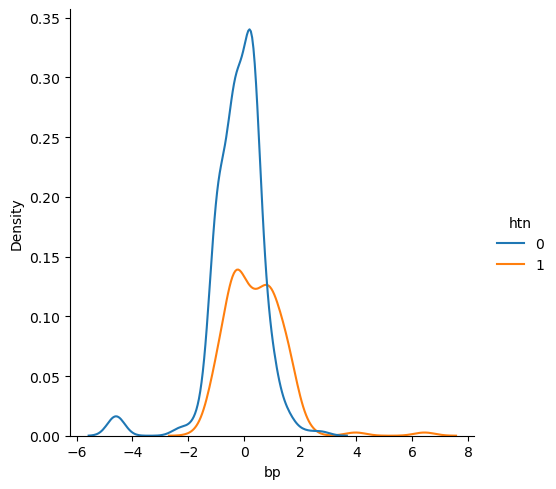

In [74]:
sns.displot(data = df, x = 'bp', hue = 'htn', kind = 'kde')

c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


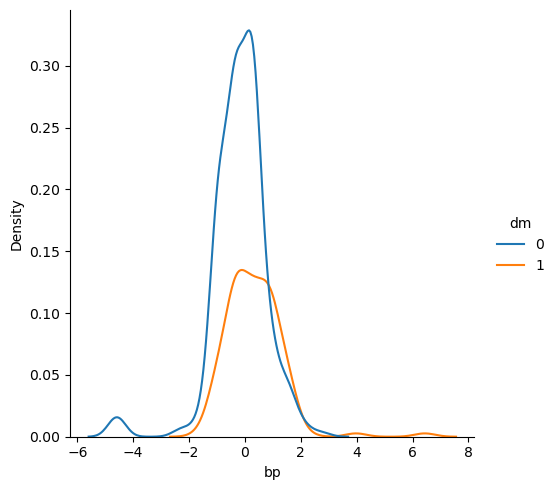

In [75]:
sns.displot(data = df, x = 'bp', hue = 'dm', kind = 'kde')

c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\udayb\OneDrive\Documents\NIMER_Stats_important\.conda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


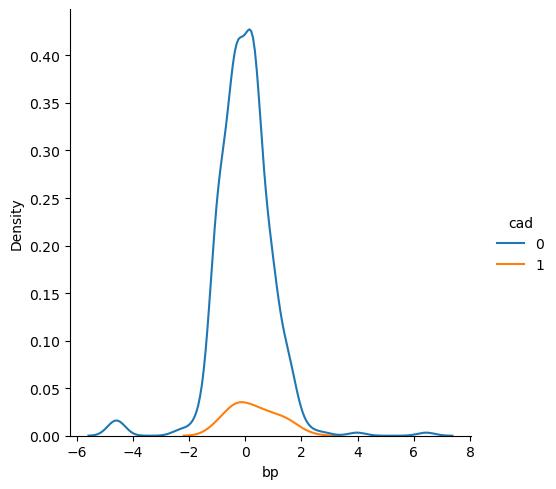

In [76]:
sns.displot(data = df, x = 'bp', hue = 'cad', kind = 'kde')

### 8. Data Splitting

In [100]:
x = df.drop(['class'], axis = 1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=1, stratify=y)

### 9. Classifier Choices

1. Decision Tree
2. Logistic Regression

Starting with **Logistic Regression**:
The response variable's distribution helps us decide on this classification choice. The `class` variable has to categories, patients who have Chronic Kidney Disease (`ckd`) and those who do not (`notckd`). The distribution of the variable tells us that logistic regression is the optimal choice for a classifier. Logistic Regression model also provides us with the ability to use categorical variables in our model.

For **Decision Trees**:
Decision tree algorithms allow for an understanding of which variables matter the most, and overcomes some limitations of methods such as KNN when faced with high dimensions. They are additionally easy to understand when someone views the output. 


### 10. Performance Metrics
The metrics we will be using include:
1. Sensitivity (proportion of chronic kidney disease cases which were correctly predicted as such, i.e. true positives)  
2. Specificity (proportion of non-CKD cases which were correctly predicted as such, i.e. true negatives)

These allow us to better understand which classification model offers the lowest misclassification rates (i.e. we want high sensitivity and specificity). More specifically, in the context of this challenge, since we are dealing with diagnosis of a disease, it is important to minimization the misclassification rate. This allows us to therefore, minimize false positives and false negatives, which is essential in a clinical/healthcare setting. Sensitivity and specificity are extremely important performance metrics and allow healthcare providers to use diagnnostic tools more effectively when the two metrics are both high (@shreffler2020diagnostic).

### 11. Feature Selection/Extraction
To perform Feature Selection/Extraction, we will be employing the use of...
1. **Pruning** for Decision Tree
2. **Forward Selection** for the Logistic Regression


Here's the code for the **Decision Tree** (the classification, performance metrics, feature selection, comparison)

### 12. Classifier Comparison

In [101]:
cs_dt = DecisionTreeClassifier(
    max_depth = 10, 
    random_state=0
) 

cs_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

**Performance Metrics**

In [102]:
pred =cs_dt.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred), index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'True'
cm.columns.name = 'Predicted'
cm

Predicted,No,Yes
True,,
No,45,0
Yes,3,72


In [103]:
TP = cm.loc['Yes', 'Yes']
FN = cm.loc['Yes', 'No']
TN = cm.loc['No', 'No']
FP = cm.loc['No', 'Yes']

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(sensitivity)
print(specificity)


0.96
1.0


The sensitivity is 96% and the specificity is 100%.

**Feature Selection:**
First, to perform feature selection for the decision tree algorithm, we will perform pruning to reduce the number of input nodes. 

In [104]:
path = cs_dt.cost_complexity_pruning_path(
    X_train, 
    y_train
)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

I will find the number of nodes at each alpha and then choose the depth with the greatest accuracy to prune the tree.

In [105]:
clfs = [] # save fitted trees with different alphas
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha
        )
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [106]:
ccp_alphas

array([0.        , 0.00935693, 0.02016532, 0.02094166, 0.06718783,
       0.33371876])

In [107]:
depth = [clf.tree_.max_depth for clf in clfs]
depth

[5, 3, 3, 2, 1, 0]

In [108]:
test_score = [clf.score(X_test, y_test) for clf in clfs]

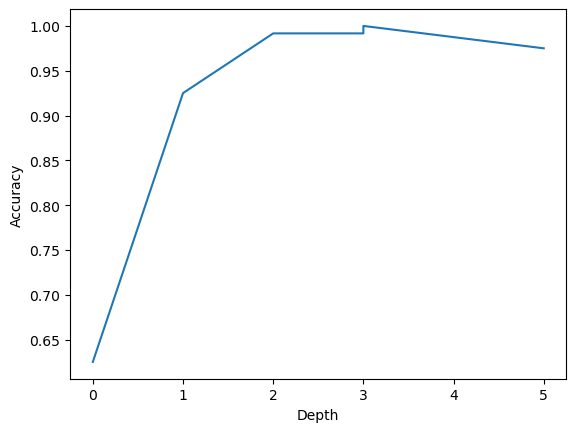

In [109]:
plt.plot(depth, test_score)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

We will choose a maximum depth of 2, since it is near the maximum accuracy, but minimizes complexity compared to greater depths.

In [110]:
cs_dt = DecisionTreeClassifier(
    max_depth = 2, 
    random_state=0
) 

cs_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [111]:
cm = pd.DataFrame(confusion_matrix(y_test, pred), index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'True'
cm.columns.name = 'Predicted'
cm

TP = cm.loc['Yes', 'Yes']
FN = cm.loc['Yes', 'No']
TN = cm.loc['No', 'No']
FP = cm.loc['No', 'Yes']

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print('Sensitivity: ', sensitivity)
print('Specificity: ',specificity)

Sensitivity:  0.96
Specificity:  1.0


**Logistic Regresion**

In [89]:
def_log = LogisticRegression()

In [90]:
def_log.fit(X_train,y_train)
pred_prob = def_log.predict_proba(X_test)

In [91]:
predicted_df = pd.DataFrame(
    data = {'prob1':pred_prob[:,1], 'y_test': y_test}
)
predicted_df.head()

,prob1,y_test
307,0.033909,0.0
131,0.023758,1.0
32,0.997078,1.0
247,0.998353,1.0
165,0.999072,1.0


In [92]:
# Cut off value (tested multiple, chose 0.3)
predicted_df['y_test_pred'] = predicted_df.prob1.map(lambda x:1 if x>0.3 else 0)
predicted_df.head()

,prob1,y_test,y_test_pred
307,0.033909,0.0,0
131,0.023758,1.0,0
32,0.997078,1.0,1
247,0.998353,1.0,1
165,0.999072,1.0,1


In [93]:
cm = confusion_matrix(predicted_df.y_test, predicted_df.y_test_pred)
print(cm)

[[45  0]
 [ 7 68]]


**Performance Metrics**

In [94]:
total = sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity =', sensitivity)
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity=', specificity)

Sensitivity = 1.0
Specificity= 0.9066666666666666


We find that we have a sensitivity of 100% and specificity is at approx. 90.67%.

Now moving to Feature Selection by **forward selection** for the Logistic Regression model.

In [96]:
sfs = SFS(
    def_log,
    k_features = (1,12),
    forward = True,
    floating = False,
    scoring ='neg_mean_squared_error',
    cv=5
)

Text(0.5, 1.0, 'Forward Selection (w. CV StdError)')

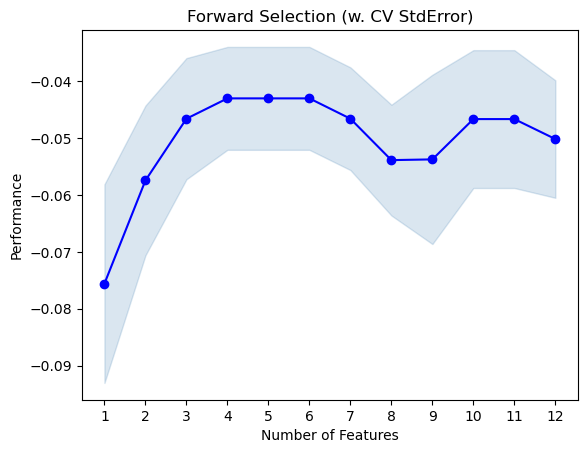

In [97]:
sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind ='std_err')
plt.title('Forward Selection (w. CV StdError)')

In [87]:
X_train.columns[list(sfs.k_feature_idx_)]

Index(['su', 'rbc', 'hemo', 'wbcc'], dtype='object')

We find that via forward selection, sugar, red blood cells, hemoglobin, white blood cell count are significant features to be included in the model. Note that by increasing the number of features we would like to explore the performance of, we could potentially increase this number. However, doing so may introduce features that may not exactly be useful in prediction, especially since performance remains constant from 4-6 features, after which it drops.

**Classifier Comparison (12)**

Based on the above results, the sensitivity and specificity are fairly high for both classifiers. The sensitivity and specificity of the Decision Tree are 96% and 100%, respectively, while for Logistic Regression is 100% and 90.67%, respectively. While both performance metrics are high, the trade-off between sensitivity and specificity is smaller with the Decision Tree. With high sensitivity and specificity we are able minimize false negative and false positive misclassification likelihoods, which are essential in a health care diagnostic tool.

### 13. Interpretable Classifier Insight

We will choosing to examine the result of the decision tree model going forward since using the scikit-learn logistic regression does not allow for statistical inference, and thus cannot interpret the significance of predictor variables. Moreover, the decision tree is also more interpretable than logistic regression, in that it gives the individual interpreting it (which in the context of this challenge will most likely be clinicians) a clear criteria required to classify someone as having CKD or not. It is easy for one to understand which factors are important in determining this and which factors are not. Conversely, logistic regression requires a deep understanding of the importance of statistical parameters (i.e. coefficients and their significance) which can be challenging and often easily misinterpreted.

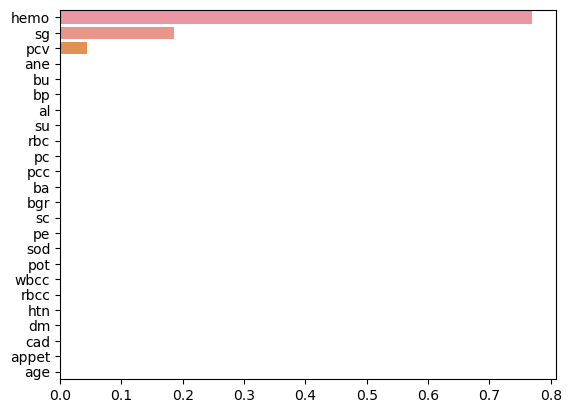

In [45]:
reg_ckd = DecisionTreeRegressor(max_depth = 2)
reg_ckd.fit(x, y)
feature_importances = reg_ckd.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = x.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]
sns.barplot(x = sorted_importances, y = sorted_feature_names)
plt.show()

In [46]:
cs_dt = DecisionTreeClassifier(
    max_depth = 2, 
    random_state=0
) 

cs_dt.fit(x, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

[Text(0.5, 0.8333333333333334, 'hemo <= 0.406\ngini = 0.47\nsamples = 398\nvalue = [150, 248]\nclass = CKD'),
 Text(0.25, 0.5, 'pcv <= 0.722\ngini = 0.066\nsamples = 234\nvalue = [8, 226]\nclass = CKD'),
 Text(0.125, 0.16666666666666666, 'gini = 0.034\nsamples = 230\nvalue = [4, 226]\nclass = CKD'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = No CKD'),
 Text(0.75, 0.5, 'sg <= 1.017\ngini = 0.232\nsamples = 164\nvalue = [142, 22]\nclass = No CKD'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 19\nvalue = [0, 19]\nclass = CKD'),
 Text(0.875, 0.16666666666666666, 'gini = 0.041\nsamples = 145\nvalue = [142, 3]\nclass = No CKD')]

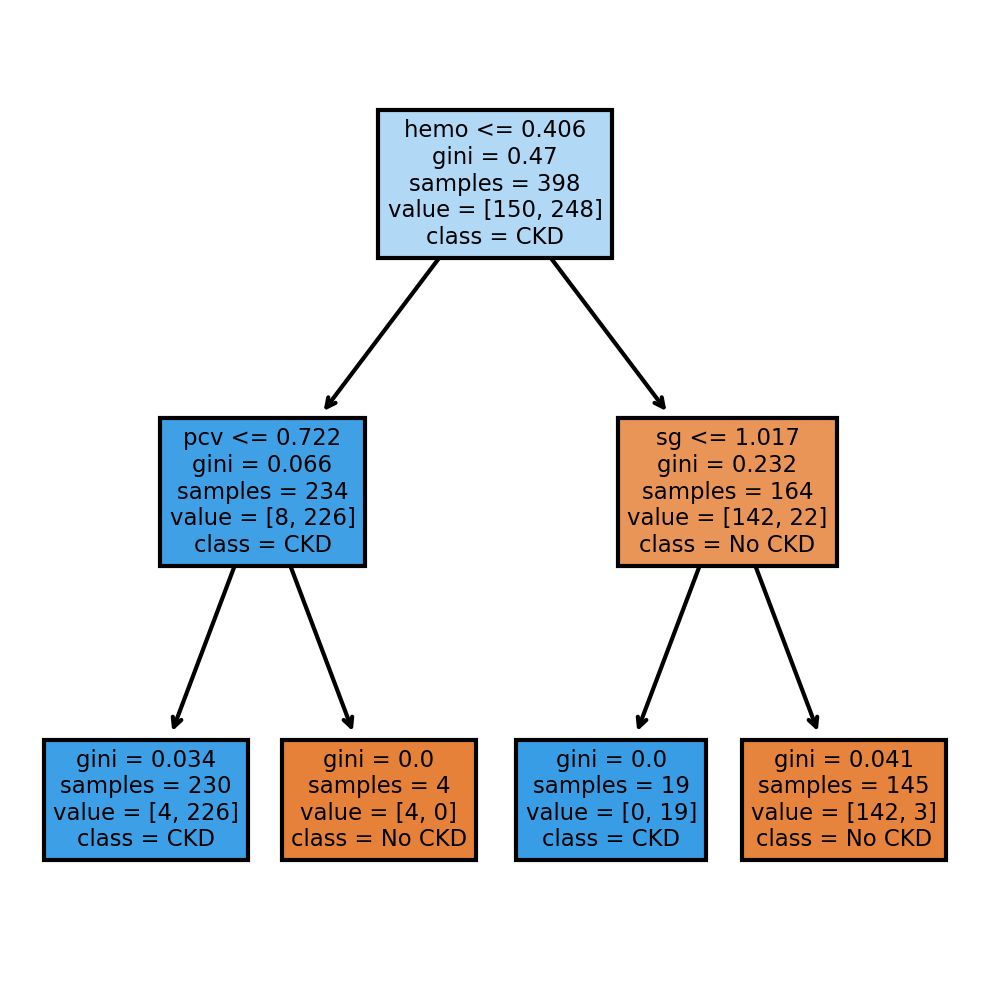

In [47]:
fig, axes = plt.subplots(
    nrows = 1,ncols = 1,figsize = (4,4), dpi=300
    )
plot_tree(
    cs_dt, 
    max_depth= 2,  
    feature_names = X_train.columns.tolist(), 
    class_names=['No CKD', 'CKD'], 
    filled = True
    )

Based on the results, the most important features are hemoglobin, packed cell volume and specific gravity for predicting whether someone will have chronic kidney disease or not.

### 15. Team Contributions

Nimer: Question 1, 2, 3, 5

Mika'il: Question 4, 6, 7

Question 8-13 were completed collectively: Nimer handled the Logistic Regression and Mikai'l handled the Decision Tree, but justifications, explanations and comparisons were drawn up together by meeting via Zoom.

### 16. Link

Here is the link the GitHub repository: [Repository LINK](https://github.com/nimerkb/Assign6/tree/main)

The final assignment file is labelled "Final_Assignment_6.ipynb". Here is this notebook's link: [NOTEBOOK LINK](https://github.com/nimerkb/Assign6/blob/main/Final_Assignment_6.ipynb)


However, the repository does contain other files which document our individual workflow in a more detailed manner. Since the two of us worked at our own pace and had a large workflows, we thought it would be best to work in separate files at least for the classification models and then bring them together after completion. Thus, the file "Nimer_A6.ipynb" contains Nimer's workflow in a more detailed manner while "Mikhail_A6.ipynb" contains Mikhail's workflow in a more detailed manner. Please note that these are simply for you to observe the workflow and we are not submitting them to be marked. The file "Final_Assignment_6.ipynb" is the assignment which we are submitting for grading.